<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/11/1112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!apt install libcairo2-dev pkg-config python3-dev
!pip install igraph leidenalg cairocffi
!wget -O funcs.py https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/11/1112_funcs.py?raw=1
!wget -O 1112_credits.csv https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/1112_credits.csv?raw=1
!wget -O 1112_titles.csv https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/1112_titles.csv?raw=1

## Clustering actors

In [2]:
import random
from itertools import combinations

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import igraph as ig

from funcs import (conductance,
        average_internal_node_degree, print_clustering_stats,
        display_network_clusters_labels
)

ig.config['plotting.backend']='matplotlib'
plt.rcParams["figure.figsize"] = (10,10)
sns.set_theme()
random.seed(2)

### Netflix movie dataset

Netflix TV Shows and Movies dataset.

This data was acquired in July 2022 containing data available in the United States.

Source : https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies?select=titles.csv

####  Analysis goal

Find groups of actors that frequently appear together.

In [3]:
actor_info_path = '1112_credits.csv'
credits_df = pd.read_csv(actor_info_path)
# each row in this table represents information about a single person in a single movie
# person_id: the person name
# id: the movie identity
# name: the person name
# character: if the person is an actor, we also have the character name
# role: the role of the person in the movie, per which could be actor or director
# we will use this table in order to create a graph of actors
# in our graph, each node will represent a single actor, and two actors will be connected with an edge if these actors appear in the same movies or shows
# we will also use edge weights, which represents the number of movies or shows, where two actors appear together

In [4]:
credits_df.head(10)

,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR
5,32267,tm84618,Peter Boyle,Wizard,ACTOR
6,519612,tm84618,Leonard Harris,Senator Charles Palantine,ACTOR
7,29068,tm84618,Diahnne Abbott,Concession Girl,ACTOR
8,519613,tm84618,Gino Ardito,Policeman at Rally,ACTOR
9,3308,tm84618,Martin Scorsese,Passenger Watching Silhouette,ACTOR


In [5]:
movie_info_path = '1112_titles.csv'
movie_info_df = pd.read_csv(movie_info_path)
movie_info_df.head()
# the second part is cluster characterization
# we will characterize our clusters based on characteristics of movies where actors from the clusters appear
# so we have the second table where each row describes a single movie
# id: the movie identity

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [6]:
credits_df['role'].unique()

array(['ACTOR', 'DIRECTOR'], dtype=object)

In [7]:
# Keep only actors
credits_df = credits_df[credits_df['role']=='ACTOR']

In [8]:
# Keep actors appearing in more than 5 shows/movies
# denoise
show_counts = credits_df['name'].value_counts().sort_values(ascending=False)
selected_actors = show_counts[show_counts > 5].index.to_list()

In [9]:
len(selected_actors)

768

In [11]:
# Remove movies with single remaining actor
credits_df = credits_df[credits_df['name'].isin(selected_actors)]
credits_df = credits_df.groupby('id').filter(lambda x: len(x) > 1)

In [12]:
# Map actors to integers
unique_actors = credits_df['name'].unique()
actor_mapping = {unique_actors[i]: i for i in range(unique_actors.shape[0])}
credits_df['actor_id'] = credits_df['name'].map(actor_mapping)

In [13]:
credits_df

,person_id,id,name,character,role,actor_id
60,11472,tm127384,Graham Chapman,King Arthur / Voice of God / Middle Head / Hic...,ACTOR,0
61,1549,tm127384,John Cleese,Second Swallow-Savvy Guard / The Black Knight ...,ACTOR,1
62,11474,tm127384,Eric Idle,Dead Collector / Peasant 1 / Sir Robin the Not...,ACTOR,2
63,11473,tm127384,Terry Gilliam,Patsy / Green Knight / Old Man from Scene 24 (...,ACTOR,3
64,11475,tm127384,Terry Jones,Dennis's Mother / Sir Bedevere / Left Head / P...,ACTOR,4
...,...,...,...,...,...,...
77778,269015,tm1014599,Richard Mofe-Damijo,Mr. George,ACTOR,723
77782,618764,tm1014599,Zainab Balogun,Temisan,ACTOR,642
77783,678884,tm1014599,Segun Arinze,NaN,ACTOR,749
77784,67123,tm1014599,Nse Ikpe-Etim,Ame,ACTOR,501


In [14]:
# Extract actors from each movie
movie_groups = credits_df.groupby('id')['actor_id'].apply(set)
movie_groups
# once we have denoised our data frame, our next task is to extract all the edges

,actor_id
id,
tm100015,"{264, 201, 310}"
tm1000551,"{723, 502}"
tm1000619,"{352, 486, 552, 360, 493, 479}"
tm100106,"{417, 418}"
tm1001095,"{635, 483}"
...,...
ts91087,"{698, 699, 463}"
ts92405,"{480, 393, 378}"
ts9246,"{368, 242}"


In [15]:
actor_combinations_count = {} # edge weights

In [16]:
# Make edge for each pair of actors acting in the same
# movie
# Edge weight is equal to the number of co-occurrences
for actors in movie_groups:
    if len(actors) > 1:
        for actor1, actor2 in combinations(actors, 2):
            actor_pair = tuple(sorted((actor1, actor2)))

            # Update count
            if actor_pair in actor_combinations_count:
                actor_combinations_count[actor_pair] += 1
            else:
                actor_combinations_count[actor_pair] = 1

In [17]:
actor_combinations_count

{(201, 264): 1,
 (264, 310): 1,
 (201, 310): 1,
 (502, 723): 1,
 (352, 486): 4,
 (352, 552): 1,
 (352, 360): 3,
 (352, 493): 1,
 (352, 479): 1,
 (486, 552): 1,
 (360, 486): 2,
 (486, 493): 1,
 (479, 486): 1,
 (360, 552): 1,
 (493, 552): 1,
 (479, 552): 1,
 (360, 493): 1,
 (360, 479): 1,
 (479, 493): 1,
 (417, 418): 3,
 (483, 635): 1,
 (67, 559): 1,
 (684, 752): 6,
 (228, 752): 6,
 (228, 684): 6,
 (225, 579): 1,
 (171, 225): 3,
 (225, 314): 1,
 (171, 579): 1,
 (314, 579): 3,
 (171, 314): 2,
 (501, 603): 2,
 (164, 171): 1,
 (164, 748): 2,
 (164, 472): 2,
 (164, 314): 1,
 (171, 748): 1,
 (171, 472): 1,
 (472, 748): 2,
 (314, 748): 1,
 (314, 472): 1,
 (326, 327): 1,
 (288, 289): 1,
 (176, 288): 1,
 (154, 288): 1,
 (287, 288): 2,
 (176, 289): 1,
 (154, 289): 1,
 (287, 289): 1,
 (154, 176): 1,
 (176, 287): 1,
 (154, 287): 1,
 (68, 227): 1,
 (227, 261): 1,
 (166, 227): 1,
 (227, 296): 1,
 (201, 227): 1,
 (227, 297): 1,
 (227, 298): 1,
 (154, 227): 1,
 (68, 261): 1,
 (68, 166): 1,
 (68, 296): 

In [18]:
len(actor_combinations_count)

8444

In [19]:
# Create graph and assign nodes
g = ig.Graph(n=len(unique_actors), edges=actor_combinations_count.keys())
g.es['weight'] = list(actor_combinations_count.values())

In [20]:
# Create graph layout
layout = g.layout("auto", weights='weight')

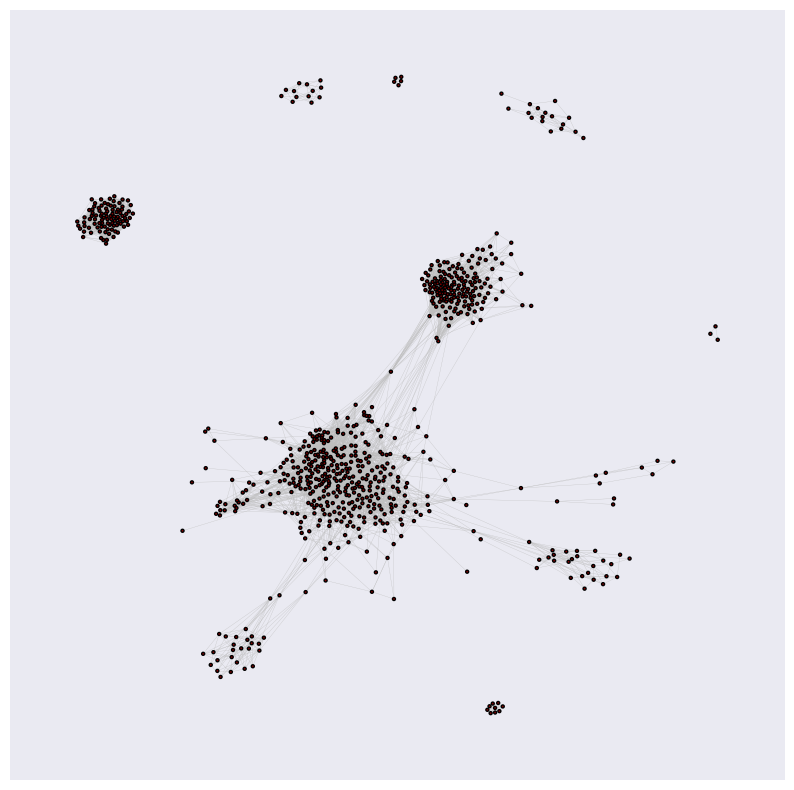

In [22]:
# Plot the graph
ig.plot(g, layout=layout, edge_width=0.2,
        vertex_size=3,
        vertex_color="darkred",
        edge_color="gray",
        background="white")
# we can identify groups of actors by looking at this layout

In [23]:
ig_clust = g.community_multilevel(resolution=1)

In [24]:
print_clustering_stats(
    ig_clusters=ig_clust,
    min_cluster_size=10
)

Cluster 1 size : 169
Cluster 2 size : 353
Cluster 3 size : 93
Cluster 4 size : 21
Cluster 5 size : 28
Cluster 9 size : 13
Cluster 10 size : 28
Cluster 11 size : 17
Num regular clusters 8
Num noise clusters 6
Num noise cluster nodes 37


In [25]:
g.modularity(ig_clust.membership)
# the modularity seems to be quite high

0.6655970740774733

In [26]:
conductance(ig_clust)
# the conductance is quite low which is good

0.02998840735810321

In [27]:
average_internal_node_degree(ig_clust)
# average internal node degree is a high value
# all of this is telling us that our clustering is of high quality

23.5291498846942

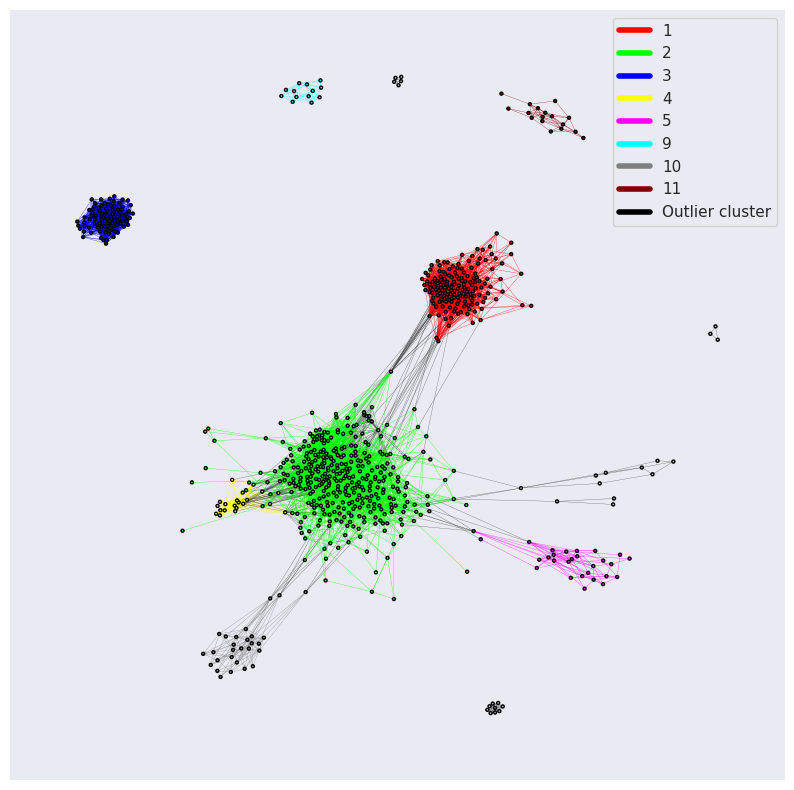

In [30]:
_ = display_network_clusters_labels(
    g_clust=ig_clust,
    layout=layout,
    edge_width=0.2,
    min_size=10,
    vertex_size=3)
# let's plot the clustering, it agrees pretty well with our graph layout

### Cluster characterization

In [31]:
movie_info_df.head()
# we will characterize our clusters by studying the movies where actors from different clusters appear

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [32]:
movie_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5850 entries, 0 to 5849
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5850 non-null   object 
 1   title                 5849 non-null   object 
 2   type                  5850 non-null   object 
 3   description           5832 non-null   object 
 4   release_year          5850 non-null   int64  
 5   age_certification     3231 non-null   object 
 6   runtime               5850 non-null   int64  
 7   genres                5850 non-null   object 
 8   production_countries  5850 non-null   object 
 9   seasons               2106 non-null   float64
 10  imdb_id               5447 non-null   object 
 11  imdb_score            5368 non-null   float64
 12  imdb_votes            5352 non-null   float64
 13  tmdb_popularity       5759 non-null   float64
 14  tmdb_score            5539 non-null   float64
dtypes: float64(5), int64(

In [33]:
movie_info_df.loc[0, 'genres']

"['documentation']"

In [34]:
from ast import literal_eval
literal_eval(movie_info_df.loc[0, 'genres'])

['documentation']

In [35]:
movie_info_df['genres'] = movie_info_df['genres'].apply(literal_eval).astype(object)
movie_info_df['production_countries'] = movie_info_df['production_countries'].apply(literal_eval).astype(object)

In [36]:
movie_info_df.head()
# now these columns will actually contain a lists of strings

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,[documentation],[US],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"[drama, crime]",[US],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"[drama, action, thriller, european]",[US],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"[fantasy, action, comedy]",[GB],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"[war, action]","[GB, US]",NaN,tt0061578,7.7,72662.0,20.398,7.600


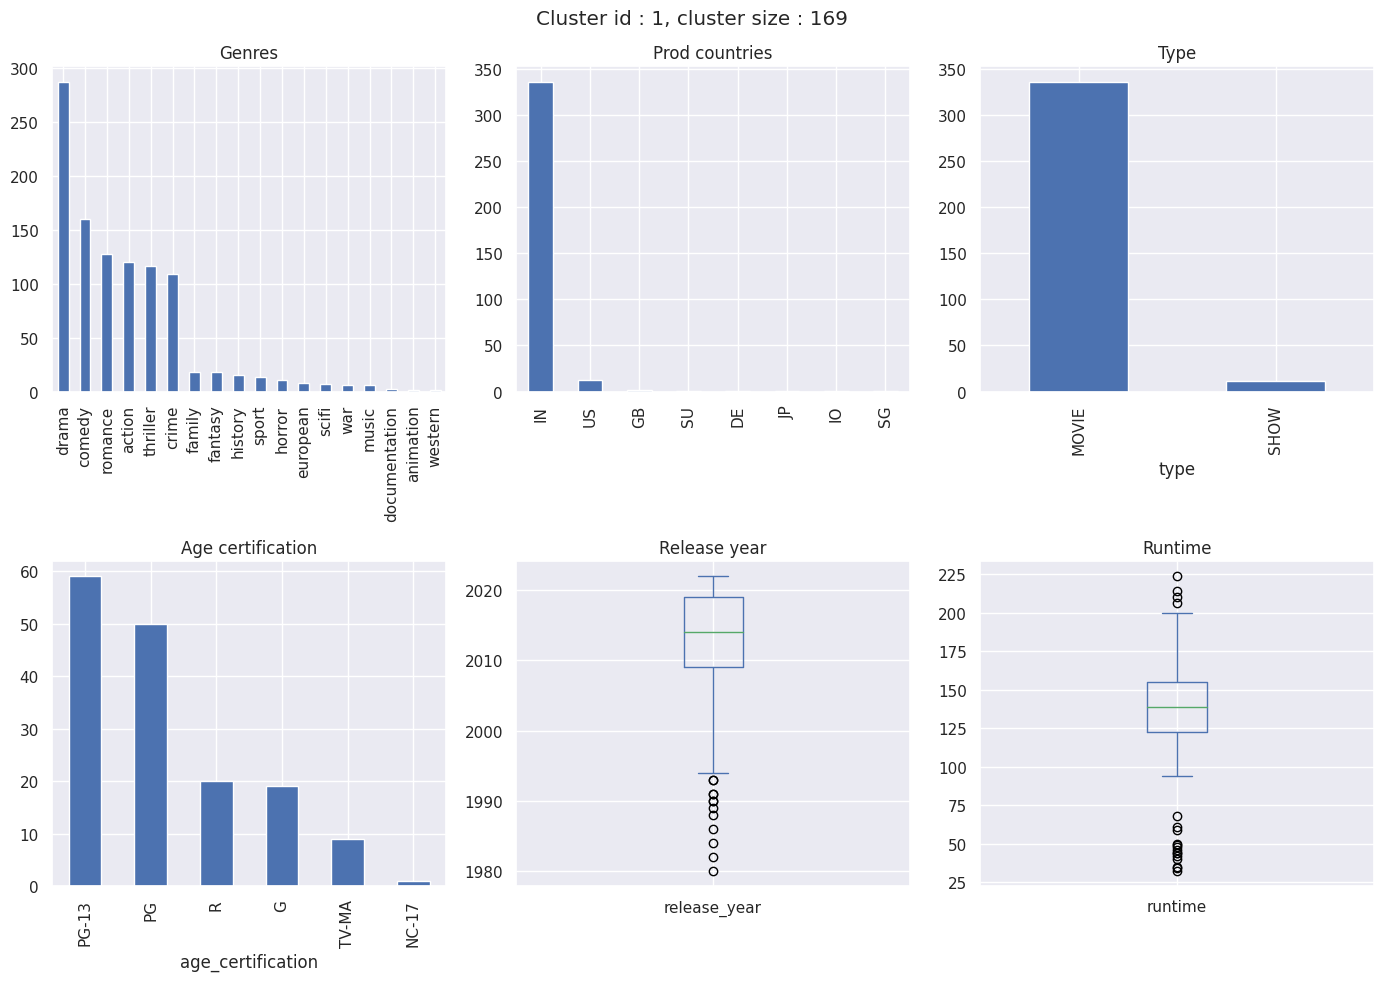

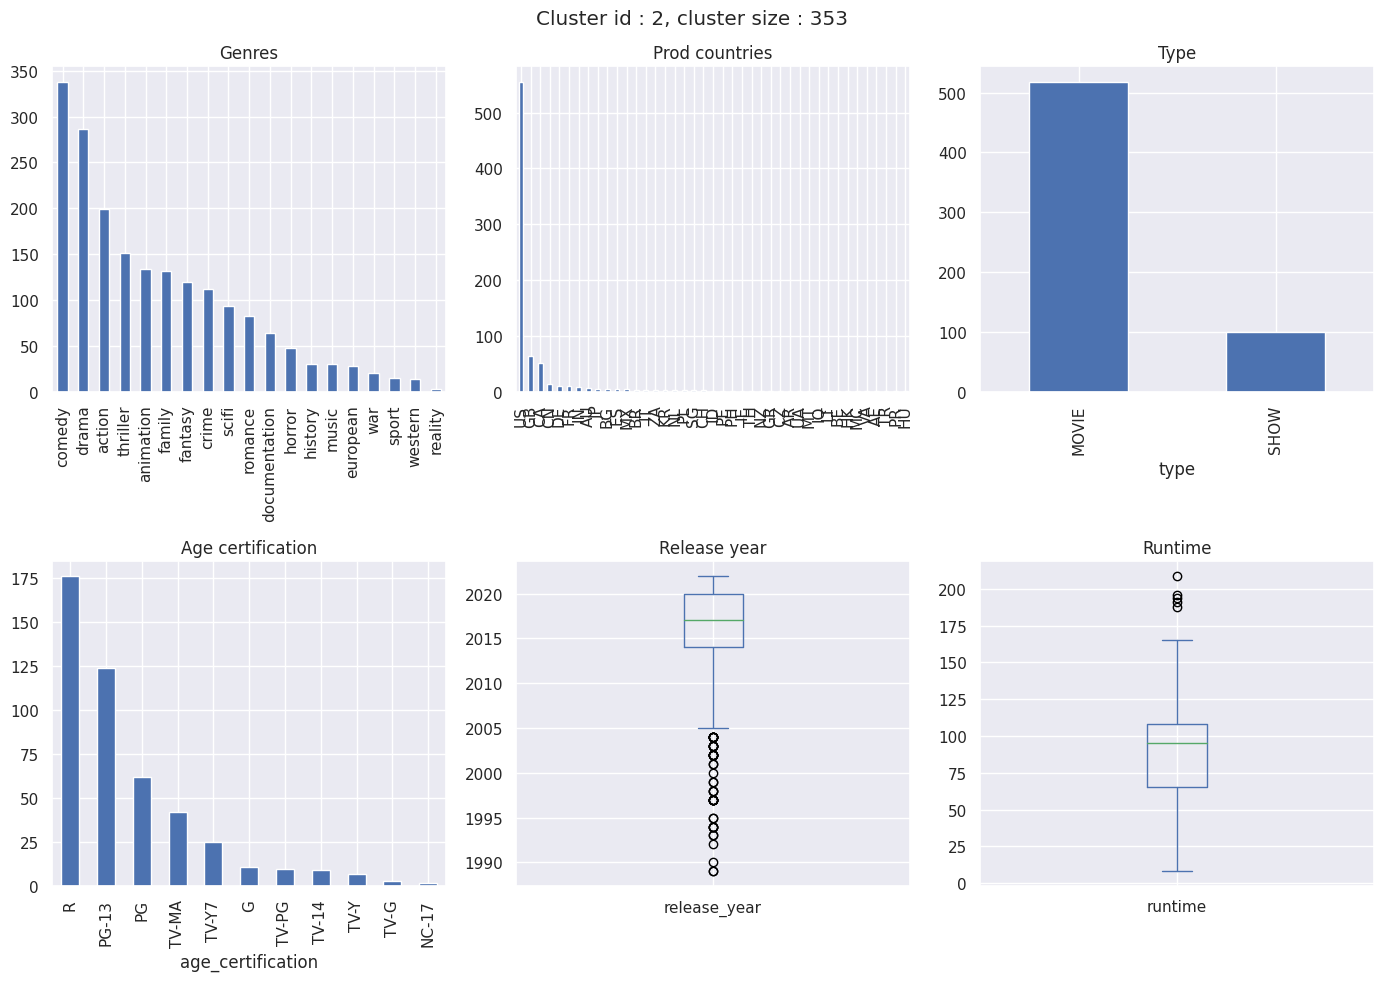

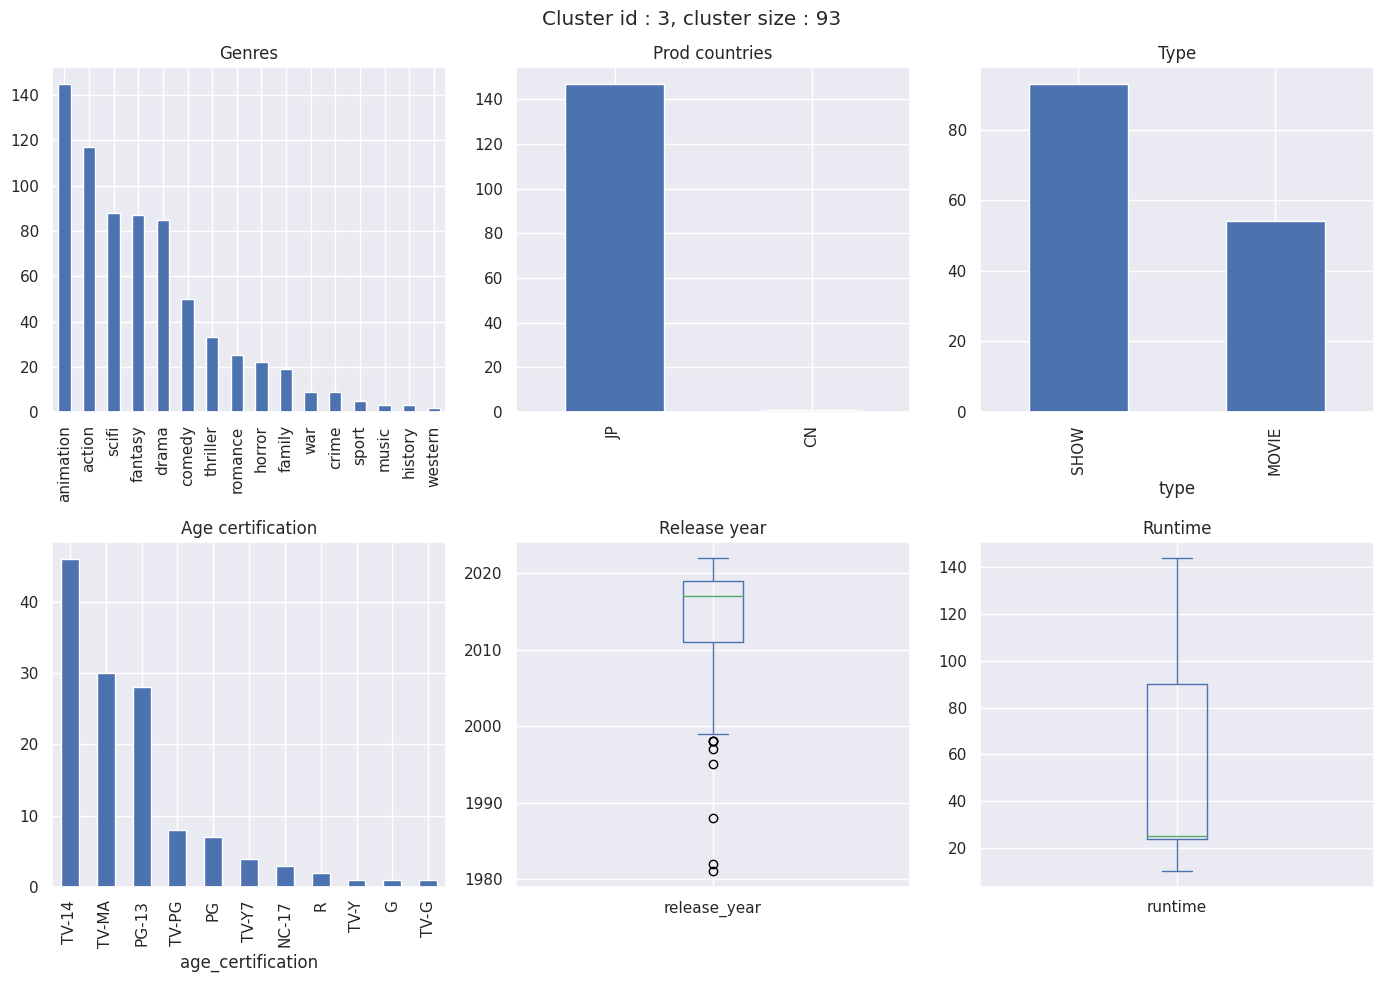

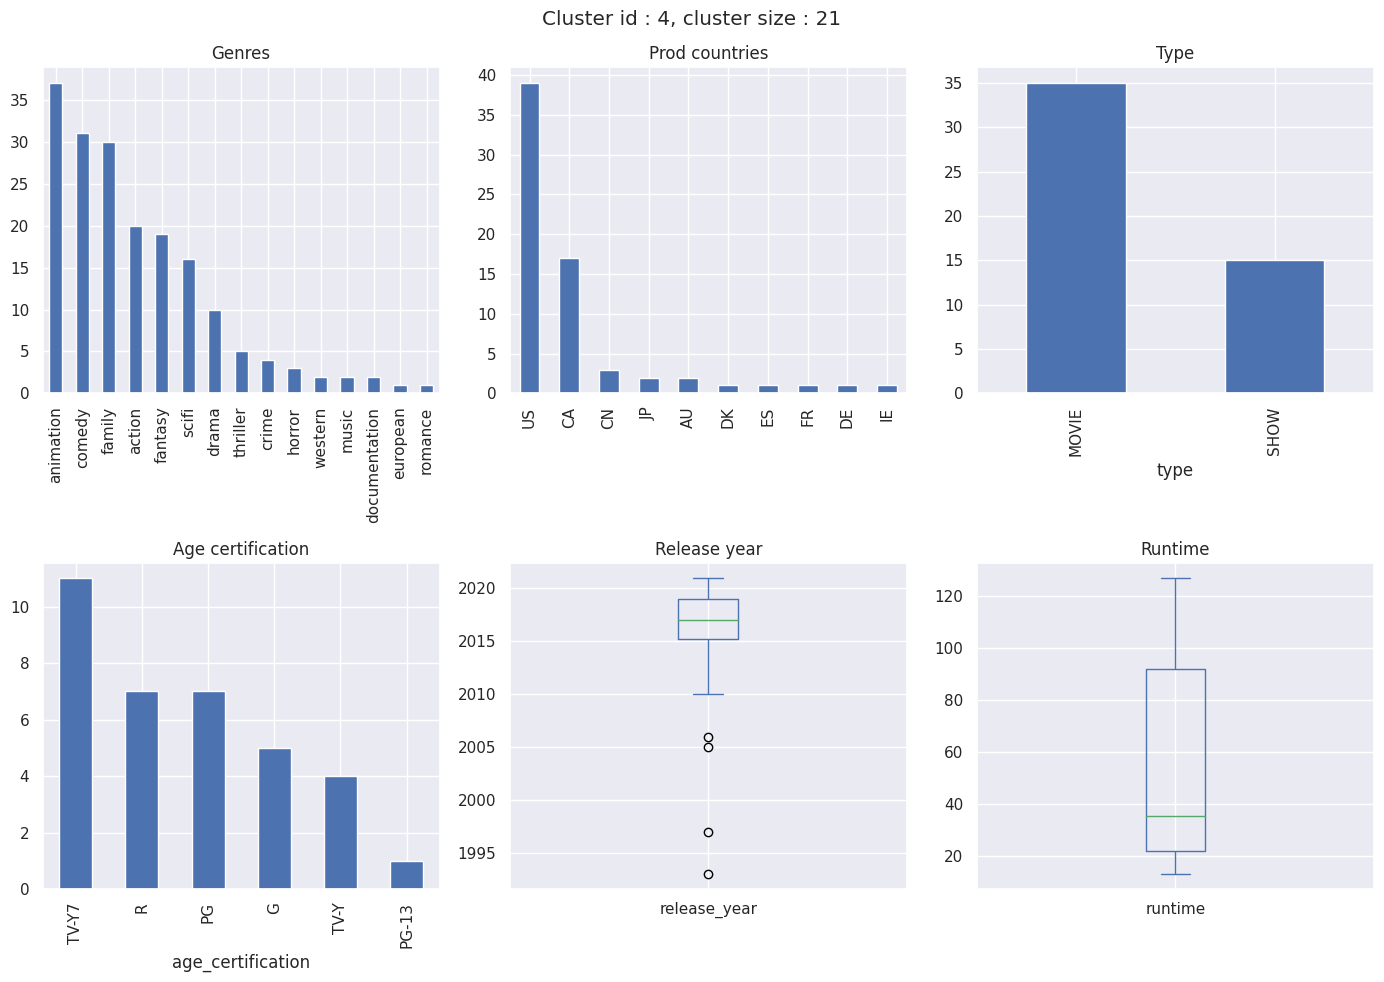

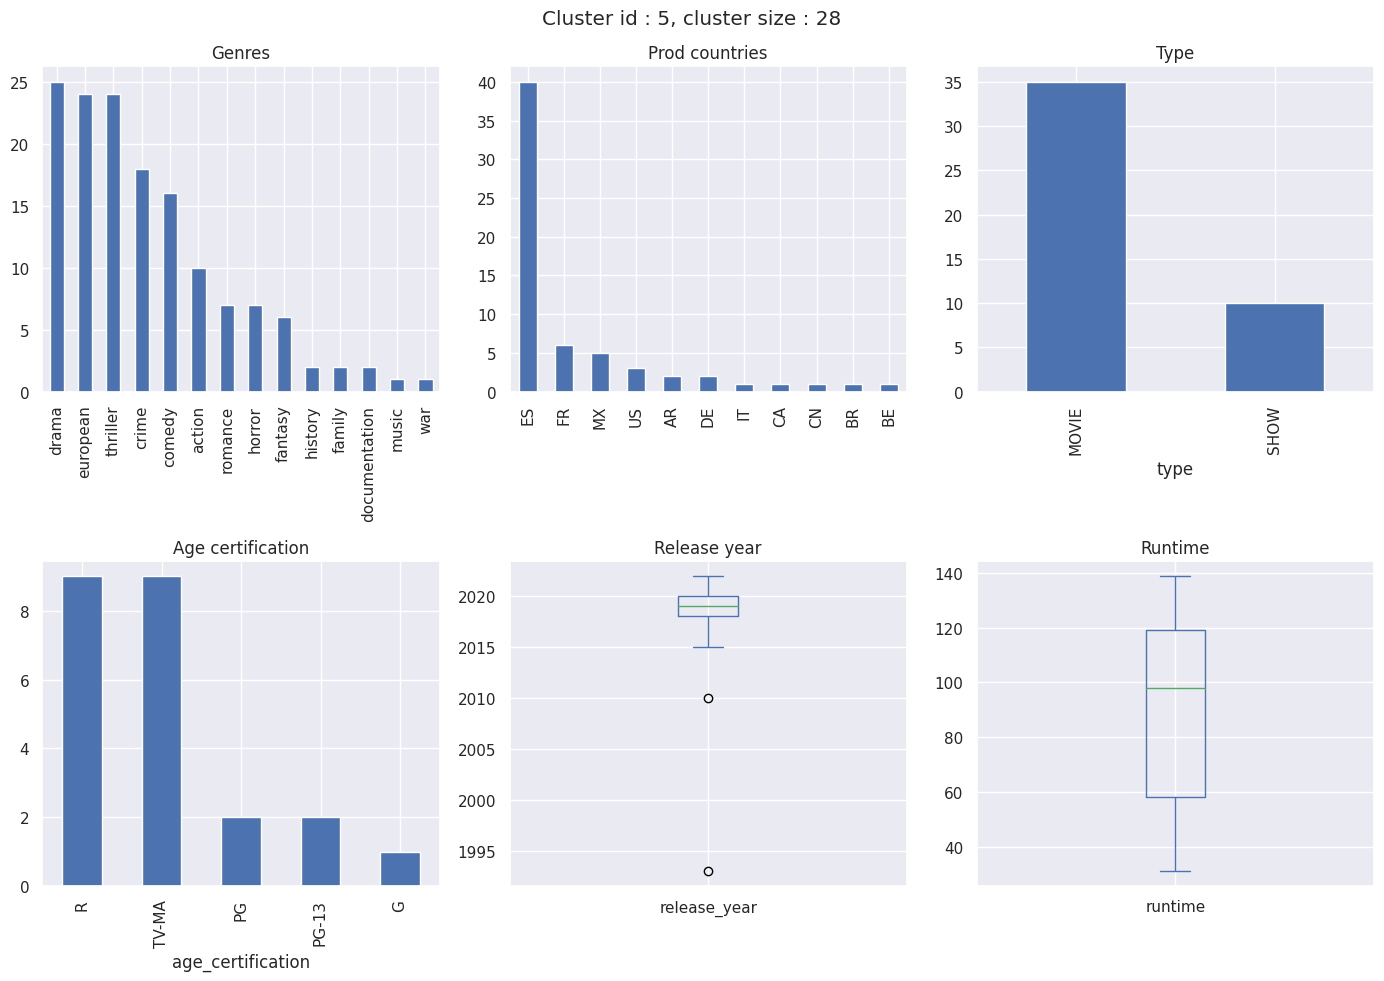

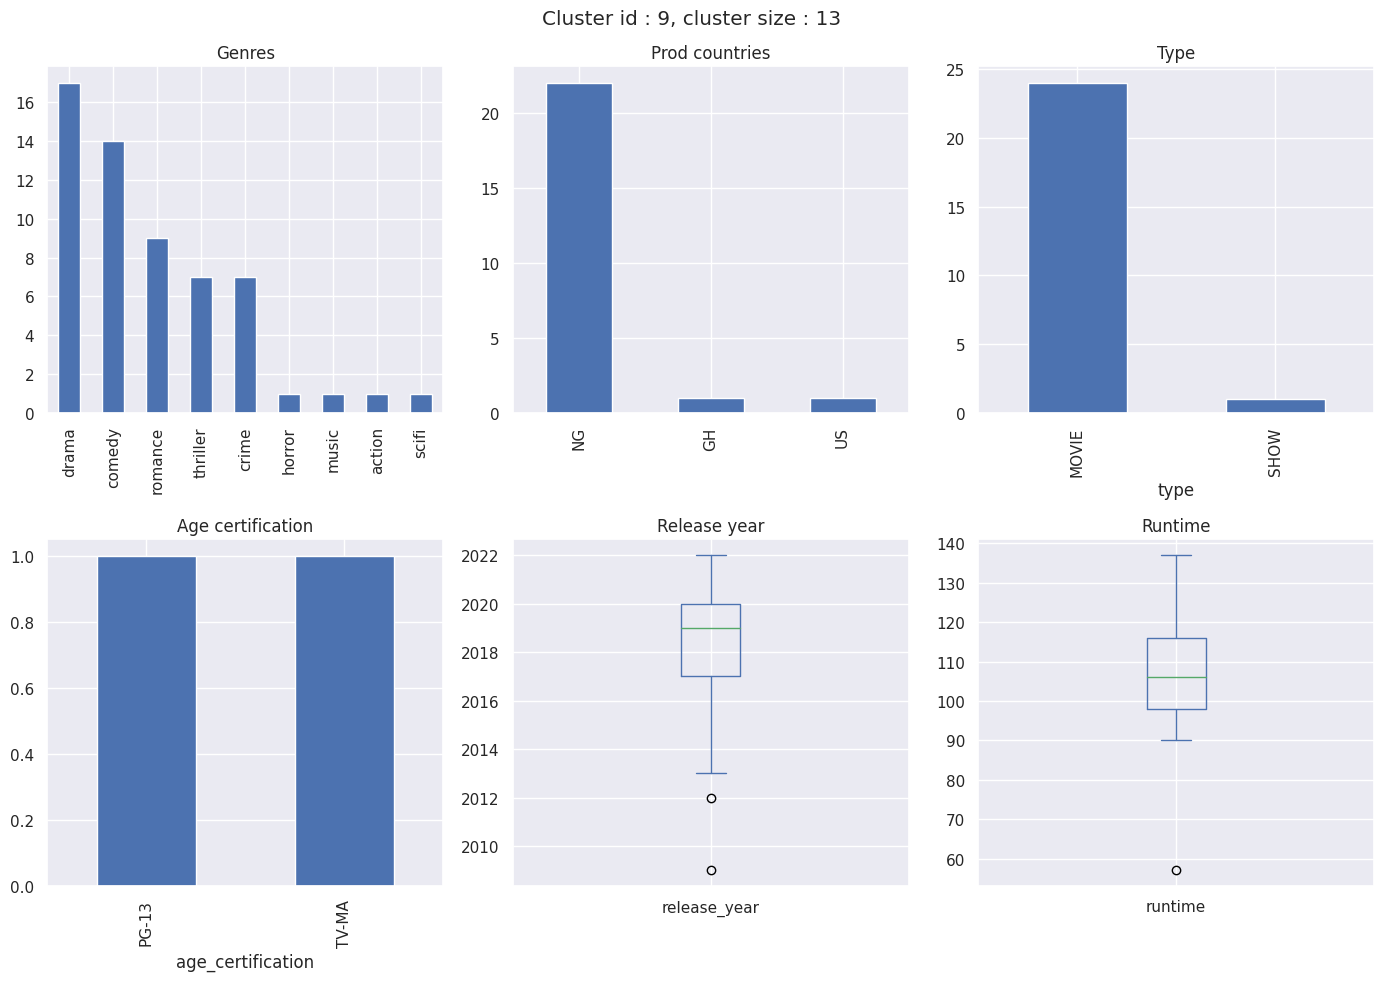

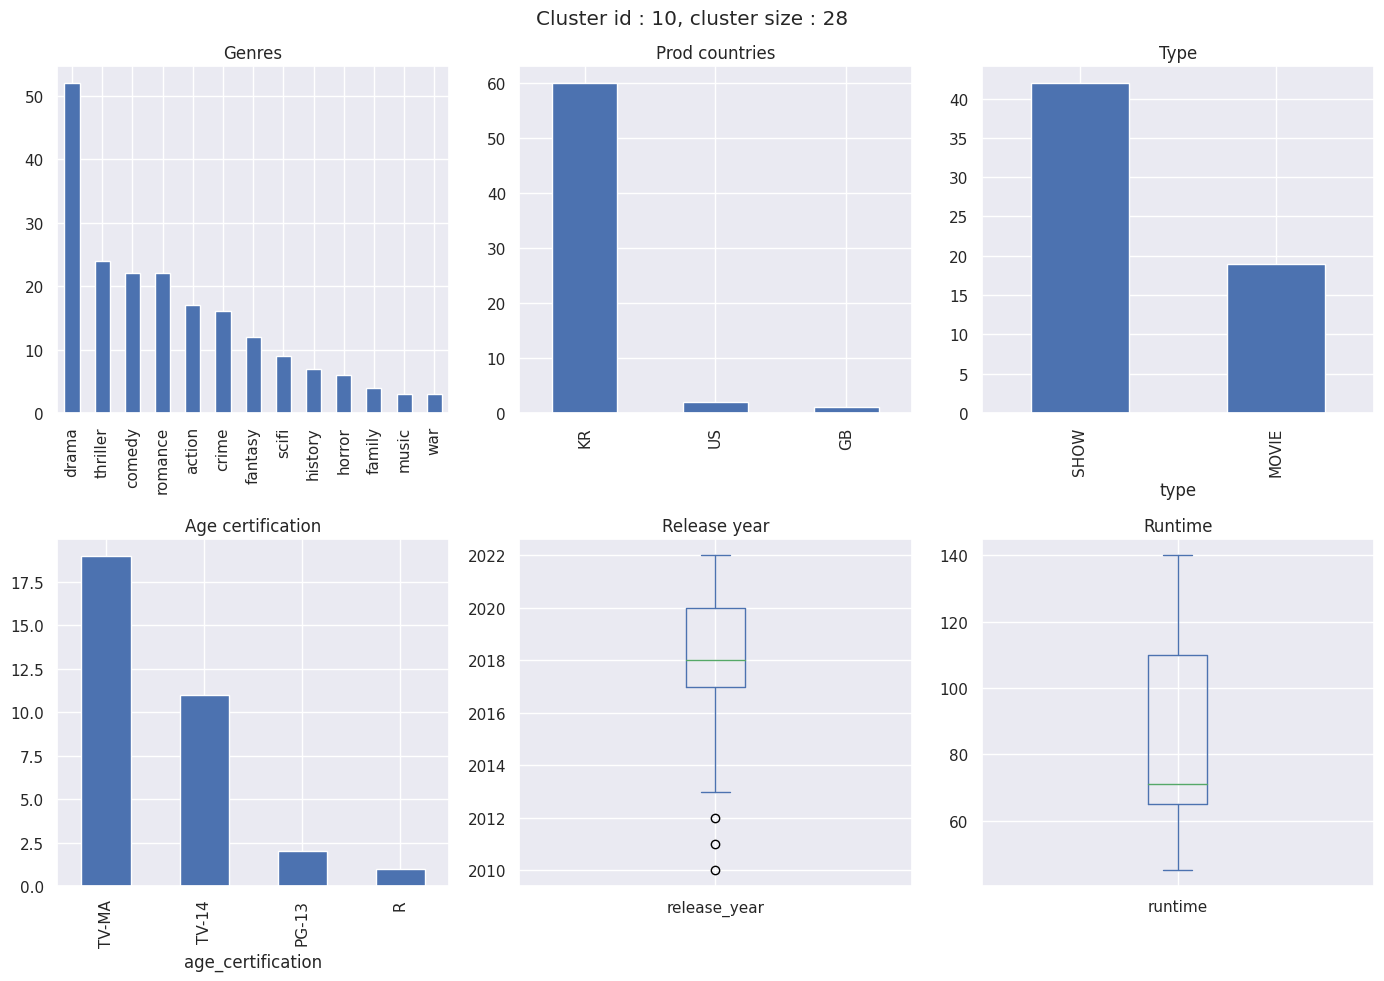

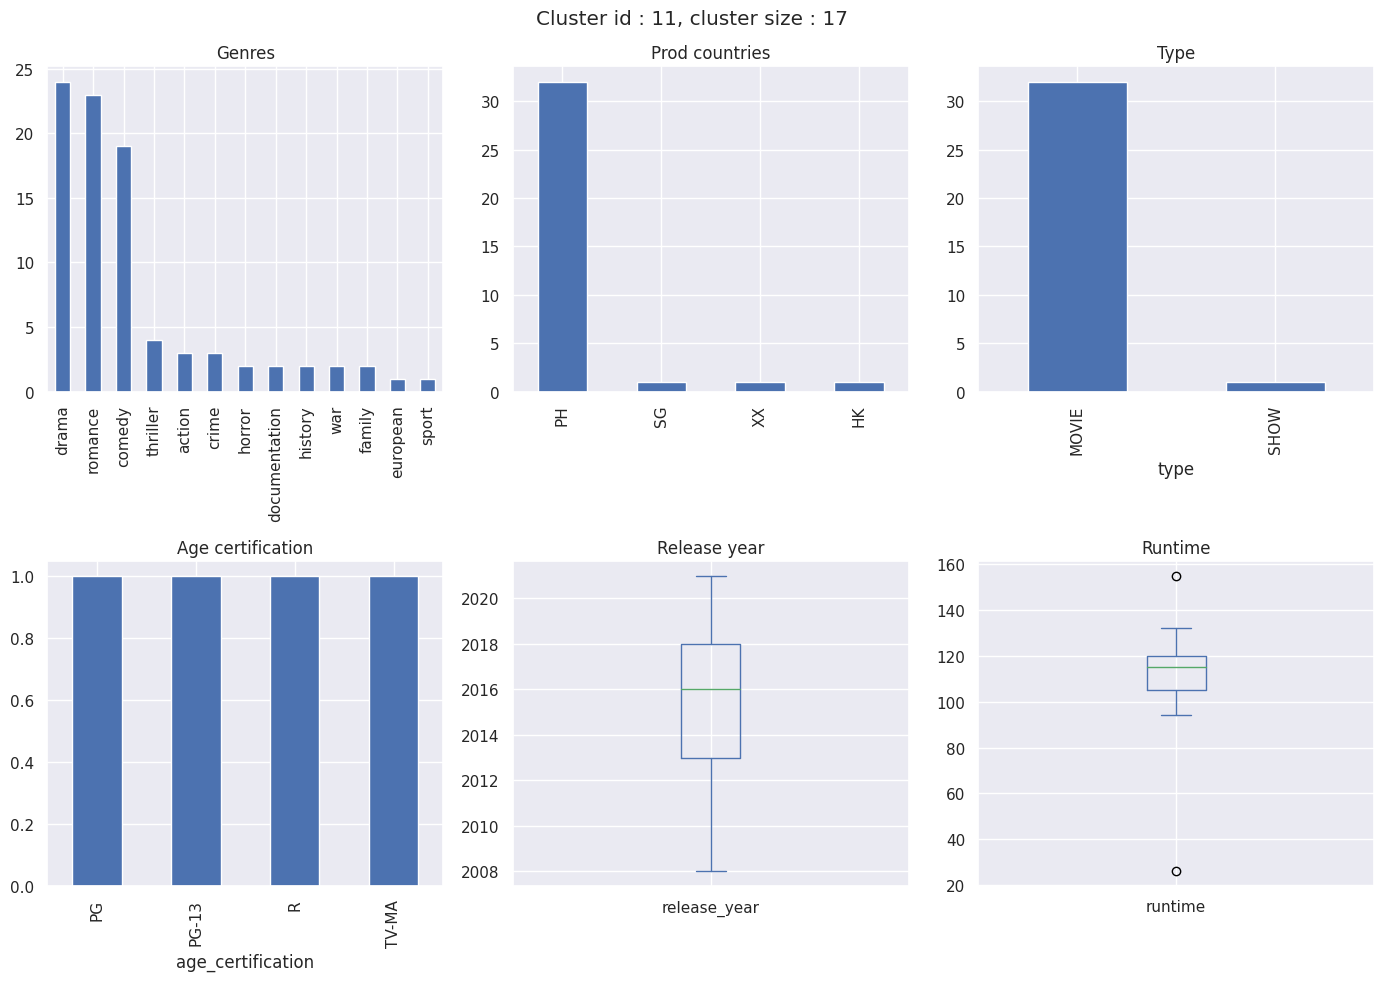

In [37]:
# Plot movie/show characteristics for all the clusters
for clust_id, clust_nodes in enumerate(ig_clust):
    # Avoid noise clusters
    if len(clust_nodes) > 10:
        fig, axs = plt.subplots(2,3, figsize=(14,10))

        axs = axs.flatten()

        # Get all movie ids corresponding to actors from current clusters
        movie_ids = credits_df.loc[credits_df['actor_id'].isin(clust_nodes), 'id'].to_list()
        movide_df_subset = movie_info_df[movie_info_df['id'].isin(movie_ids)]

        # Get genres and production countries
        clust_genres = [
            genre for genre_sublist in movide_df_subset['genres'].to_list()
            for genre in genre_sublist
        ]
        clust_prod_country = [
            prod_country for prod_country_sublist in movide_df_subset['production_countries'].to_list()
            for prod_country in prod_country_sublist
        ]

        pd_genres = pd.Series(clust_genres)
        pd_genres.value_counts().plot.bar(ax=axs[0])
        axs[0].set_title('Genres')

        pd_clust_prod_country = pd.Series(clust_prod_country)
        pd_clust_prod_country.value_counts().plot.bar(ax=axs[1])
        axs[1].set_title('Prod countries')

        # Display the type
        movide_df_subset['type'].value_counts().plot.bar(ax=axs[2])
        axs[2].set_title('Type')

        # Display age certification
        movide_df_subset['age_certification'].value_counts().plot.bar(ax=axs[3])
        axs[3].set_title('Age certification')

        # Display release year
        movide_df_subset['release_year'].plot.box(ax=axs[4])
        axs[4].set_title('Release year')

        # Display runtime
        movide_df_subset['runtime'].plot.box(ax=axs[5])
        axs[5].set_title('Runtime')

        plt.suptitle('Cluster id : {}, cluster size : {}'.format(clust_id, len(clust_nodes)))
        plt.tight_layout()

        plt.show()